In [ ]:
import pandas as pd
import glob
import networkx as nx
import matplotlib.pyplot as plt
files = glob.glob('data\AQI_all_station2024_11_*.xlsx')
print(files) 

In [ ]:
files = glob.glob('data\AQI_all_station2024_11_*.xlsx')
data_frames = []

for file in files:
    print(f"Reading file: {file}")  
    df = pd.read_excel(file)

    if df.empty:
        print(f"Warning: {file} is empty!")
    else:
        print(f"Data from {file} loaded successfully!")

    data_frames.append(df)

if not data_frames:
    print("No DataFrames to concatenate!")
else:
    combined_df = pd.concat(data_frames, ignore_index=True)
    print("Data concatenated successfully!")


In [ ]:
files = glob.glob('data/AQI_all_station2024_11_*.xlsx')

combined_df = pd.DataFrame()
for file in files:
    print(f"Reading file: {file}")  
    df = pd.read_excel(file)
    if 'State' in df.columns and 'City' in df.columns and 'Station Name' in df.columns:
        relevant_columns = df[[ 'Station Name', df.columns[-1]]] 
        relevant_columns.columns = [ 'Station Name', 'Current AQI value'] 
        date_str = file.replace('.xlsx', '') 
        relevant_columns = relevant_columns.rename(columns={'Current AQI value': f'AQI_{date_str}'})
        if combined_df.empty:
            combined_df = relevant_columns
        else:
            combined_df = pd.merge(combined_df, relevant_columns, on=['Station Name'], how='outer')

    else:
        print(f"Warning: Missing expected columns in file: {file}")
combined_df.to_excel('combined_aqi_by_station_columns.xlsx', index=False)


In [ ]:

combined_df = pd.read_excel('combined_aqi_by_station_columns.xlsx')
sample_file = 'data/AQI_all_station2024_11_22T12_00_00Z.xlsx'
sample_df = pd.read_excel(sample_file)
sample_df['State'] = sample_df['State'].ffill()
sample_df['City'] = sample_df['City'].ffill()
combined_df = pd.merge(combined_df, sample_df[['City', 'State', 'Station Name']], on='Station Name', how='left')
combined_df.to_excel('combined_aqi_by_station_columns_with_location.xlsx', index=False)


In [ ]:
combined_df = pd.read_excel('combined_aqi_by_station_columns_with_location.xlsx')
print(combined_df.head())
combined_df = combined_df.sort_values(['State', 'City'])
combined_df.to_excel('combined_aqi_by_station_columns_with_location_sorted.xlsx', index=False)



In [ ]:

combined_df = pd.read_excel('combined_aqi_by_station_columns_with_location_sorted.xlsx')
aqi_columns = [col for col in combined_df.columns if col.startswith('AQI_')]
print(aqi_columns)  
combined_df = combined_df.rename(columns={col: col.split('_')[-3][:2] for col in aqi_columns})
print(combined_df.columns)
combined_df.to_excel('final.xlsx', index=False)

In [ ]:
combined_df = pd.read_excel('final.xlsx')
aqi_columns = [col for col in combined_df.columns if col.isdigit()]
print(aqi_columns)  
combined_df = combined_df.replace('Insufficient data available in last 24 hours.', pd.NA)
for col in aqi_columns:
    combined_df[col] = combined_df.groupby(['State'])[col].transform(lambda x: x.fillna(x.mean()))
combined_df.to_excel('final_with_avg_aqi.xlsx', index=False)

In [ ]:
df = pd.read_excel('final_with_avg_aqi.xlsx')
df.to_csv('final_with_avg_aqi.csv', index=False)



In [ ]:
combined_df = pd.read_csv('final_with_avg_aqi.csv')
numeric_columns = combined_df.select_dtypes(include=['number']).columns
def replace_nan_with_row_mean(row):
    row_mean = row[numeric_columns].mean()
    return row.fillna(row_mean)
combined_df = combined_df.apply(replace_nan_with_row_mean, axis=1)
combined_df.to_csv('final_with_avg_aqi_no_nan.csv', index=False)


In [ ]:
combined_df = pd.read_csv('final_with_avg_aqi_no_nan.csv')
numeric_columns = combined_df.select_dtypes(include=['number']).columns
combined_df[numeric_columns] = combined_df[numeric_columns].astype(int)
combined_df.to_csv('final_with_avg_aqi_no_nan_int.csv', index=False)

C:\Users\halog\AppData\Local\Temp\ipykernel_12696\1464626400.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


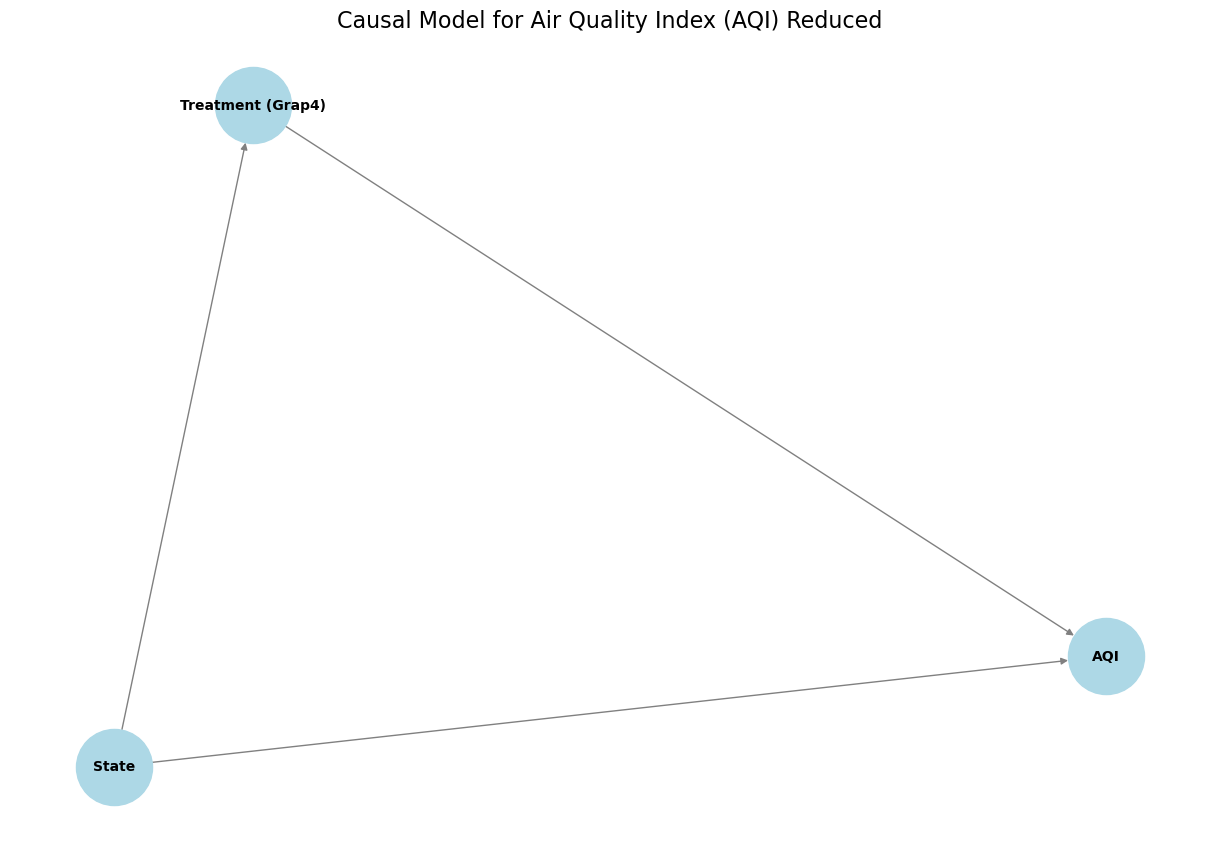

In [ ]:
G = nx.DiGraph()

nodes = [
    'State', 
    'Treatment (Grap4)', 
    'AQI'
]

G.add_nodes_from(nodes)

edges = [
    ('State', 'Treatment (Grap4)'),
    ('State', 'AQI'),
    ('Treatment (Grap4)', 'AQI'),
]

G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.9, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, 
        font_weight='bold', arrows=True, 
        edge_color='gray')

plt.title("Causal Model for Air Quality Index (AQI) Reduced", fontsize=16)
plt.tight_layout()
plt.show()